In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from allcause.data import get_all_mortality_data

In [2]:
data = get_all_mortality_data()

In [3]:
data['yearmonth'] = data.apply(lambda x: datetime(x.year, x.monthdth, 1), axis=1)

# Forecasting deaths for men

In [4]:
from prophet import Prophet

/usr/local/anaconda3/envs/allcause/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
age_recode_map = {
    1 : '<1 year',
    2 : '1-4 years',
    3 : '5-14 years',
    4 : '15-24 years',
    5 : '25-34 years',
    6 : '35-44 years',
    7 : '45-54 years',
    8 : '55-64 years',
    9 : '65-74 years',
    10 : '75-84 years',
    11 : '85+ years',
    12 : 'Age not stated'
}

sex_map = {
    'M' : 'Males',
    'F' : 'Females'
}

years_train = list(range(2000, 2020))
years_test = [2020, 2021]

In [6]:
sex_map

{'M': 'Males', 'F': 'Females'}

In [7]:
agerecode = 9
sex='M'

def compute_execss_deaths(agerecode:int,
                         sex:str,
                         data:pd.DataFrame):
    """
    Uses timeseries modeling to computed excess deaths
    during 2020 and 2021
    """



    train_cols = ['yearmonth', 'death_count']
    rename_map = {
        'yearmonth' : 'ds',
        'death_count' : 'y'
    }
    
    data_use = data[
        (data.sex==sex) &
        (data.ager12 == agerecode)
    ]

    train = data_use[data_use.year.isin(years_train)][train_cols].rename(rename_map, axis=1)
    test = data_use[data_use.year.isin(years_test)][train_cols].rename(rename_map, axis=1)
    
    m = Prophet(weekly_seasonality=False,
           daily_seasonality=False)

    m.fit(train)
    
    future = m.make_future_dataframe(periods=25, freq='M')
    future['ds'] = future.ds.apply(lambda x: datetime(x.year, x.month, 1))
    forecast = m.predict(future)
    
    fig = m.plot(forecast)
    plt.plot(test['ds'], test['y'], color='red')
    plt.xlabel('Year')
    plt.ylabel('All Cause Deaths')
    
    
    future_forecast = forecast[forecast.ds >= datetime(2020, 1, 1)]
    excess_deaths = test['y'].values - future_forecast['yhat'].values
    
    excess_fig = plt.figure()
    plt.plot(test.ds, excess_deaths)
    plt.xticks(rotation=30)
    plt.ylabel('Excess Deaths')
    plt.title(f"Excess Deaths for {sex_map[sex]} aged {age_recode_map[agerecode]}")
    
    
    
    excess_trend_df = pd.DataFrame(
    {
        'yearmonth' : test.ds.values,
        'excess_deaths' : excess_deaths,
        'expected_deaths' : future_forecast['yhat'].values
    })

    excess_trend_df['sex'] = sex
    excess_trend_df['ager12'] = agerecode
    
    return excess_fig, excess_trend_df, fig

    

In [8]:
#fig2 = m.plot_components(forecast)

08:56:16 - cmdstanpy - INFO - Chain [1] start processing
08:56:16 - cmdstanpy - INFO - Chain [1] done processing


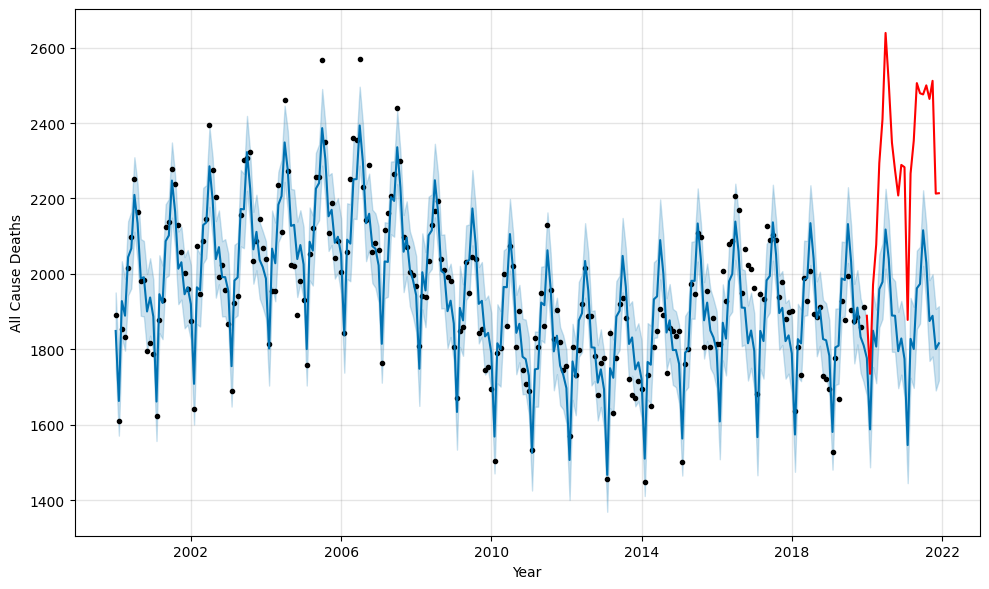

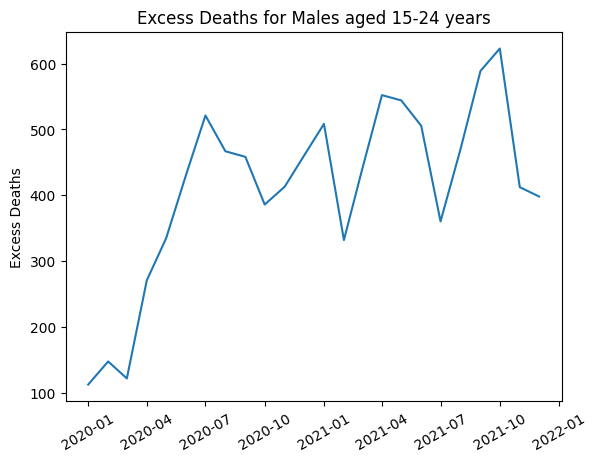

In [8]:
excess_fig, excess_trend_df, fig = compute_execss_deaths(4, 'M',data)

18:21:38 - cmdstanpy - INFO - Chain [1] start processing
18:21:39 - cmdstanpy - INFO - Chain [1] done processing
18:21:39 - cmdstanpy - INFO - Chain [1] start processing
18:21:39 - cmdstanpy - INFO - Chain [1] done processing
18:21:39 - cmdstanpy - INFO - Chain [1] start processing
18:21:39 - cmdstanpy - INFO - Chain [1] done processing
18:21:40 - cmdstanpy - INFO - Chain [1] start processing
18:21:40 - cmdstanpy - INFO - Chain [1] done processing
18:21:40 - cmdstanpy - INFO - Chain [1] start processing
18:21:40 - cmdstanpy - INFO - Chain [1] done processing
18:21:41 - cmdstanpy - INFO - Chain [1] start processing
18:21:41 - cmdstanpy - INFO - Chain [1] done processing
18:21:42 - cmdstanpy - INFO - Chain [1] start processing
18:21:42 - cmdstanpy - INFO - Chain [1] done processing
18:21:42 - cmdstanpy - INFO - Chain [1] start processing
18:21:42 - cmdstanpy - INFO - Chain [1] done processing
18:21:42 - cmdstanpy - INFO - Chain [1] start processing
18:21:43 - cmdstanpy - INFO - Chain [1]

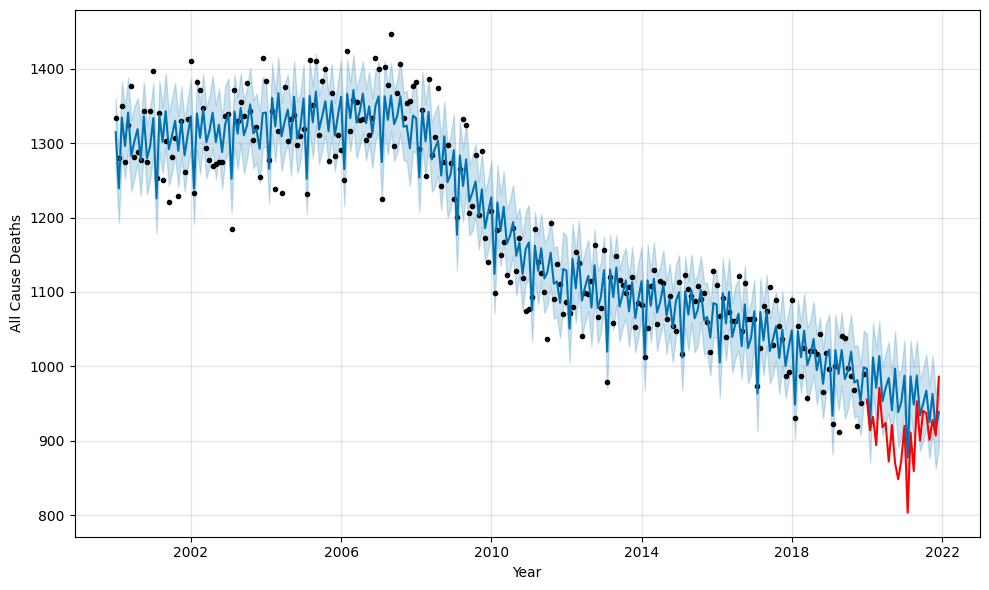

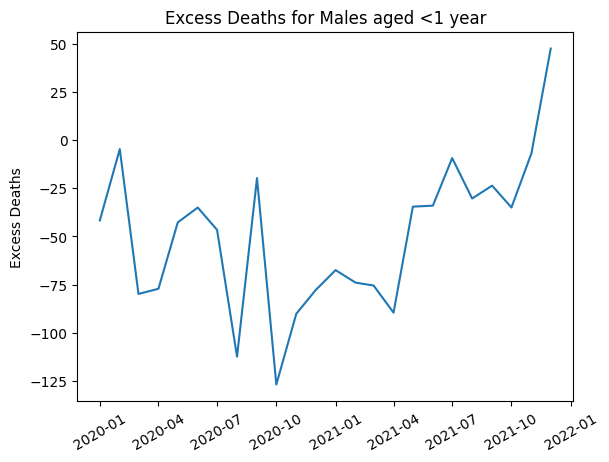

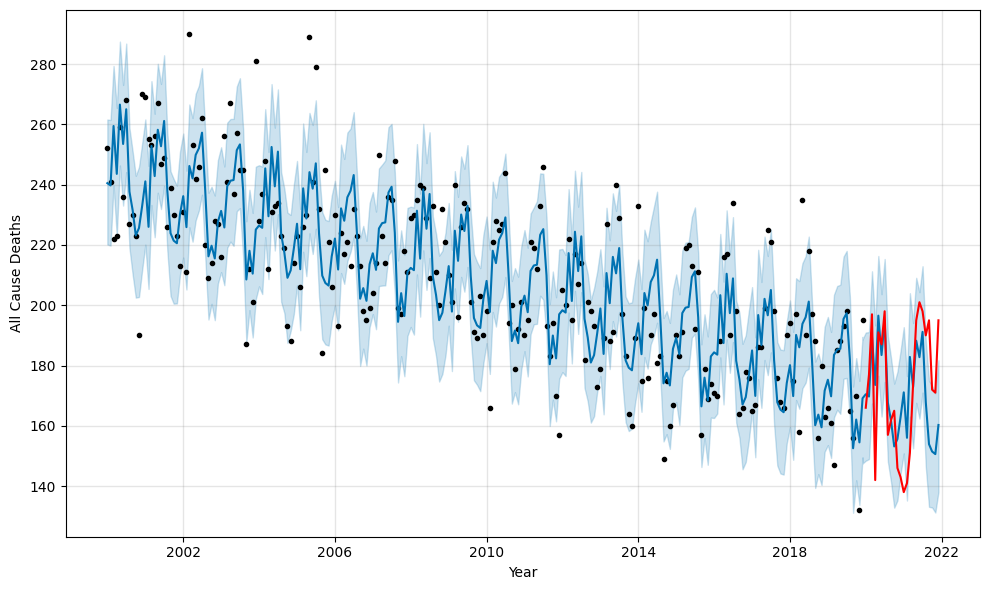

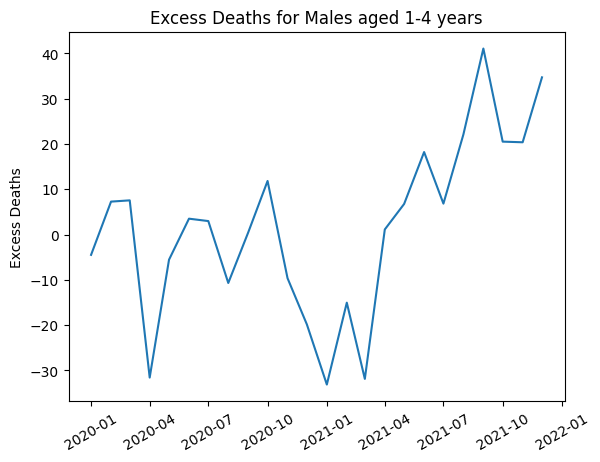

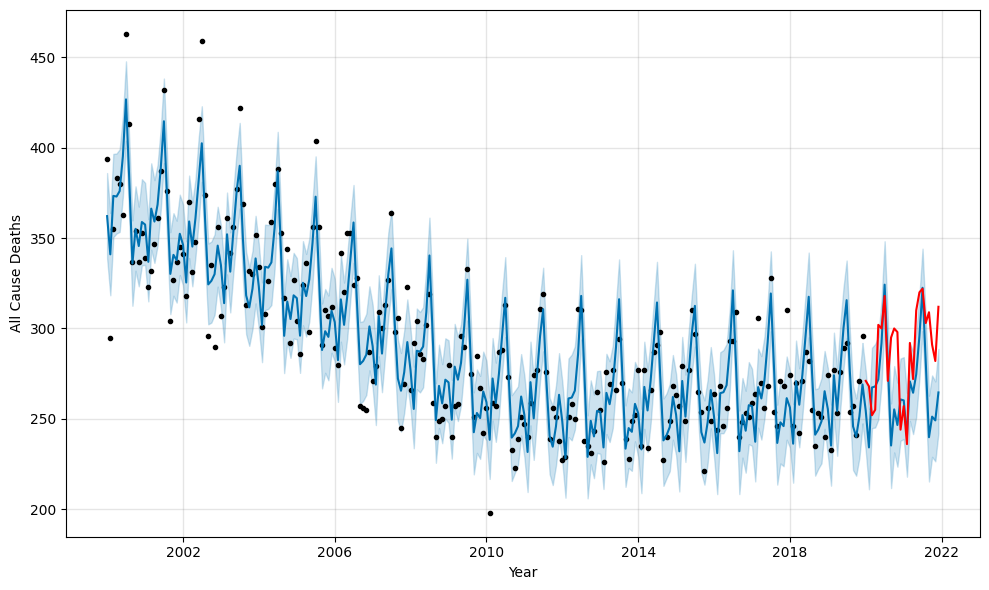

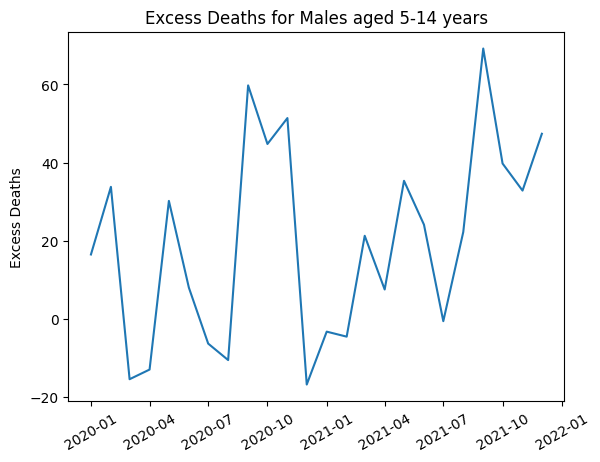

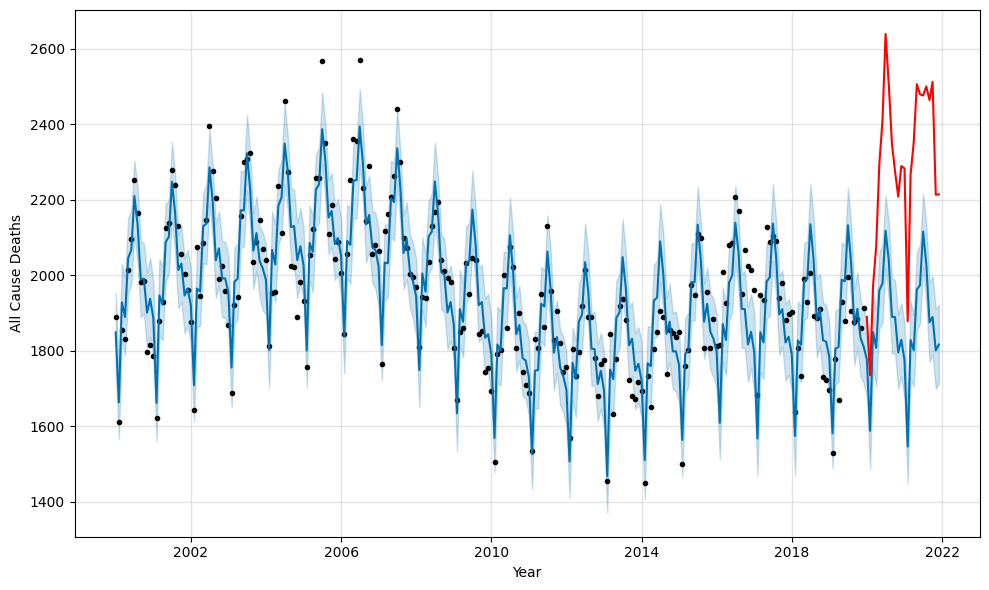

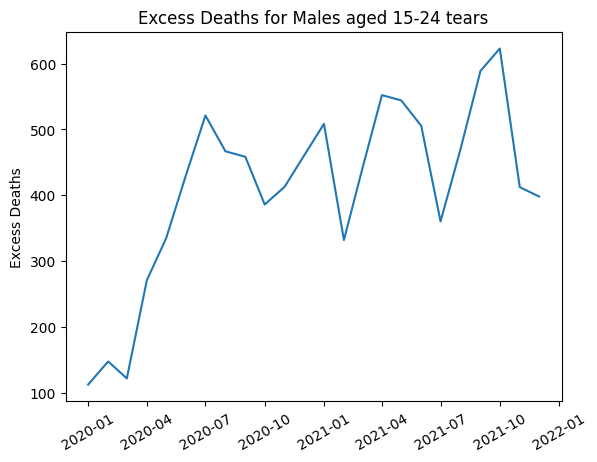

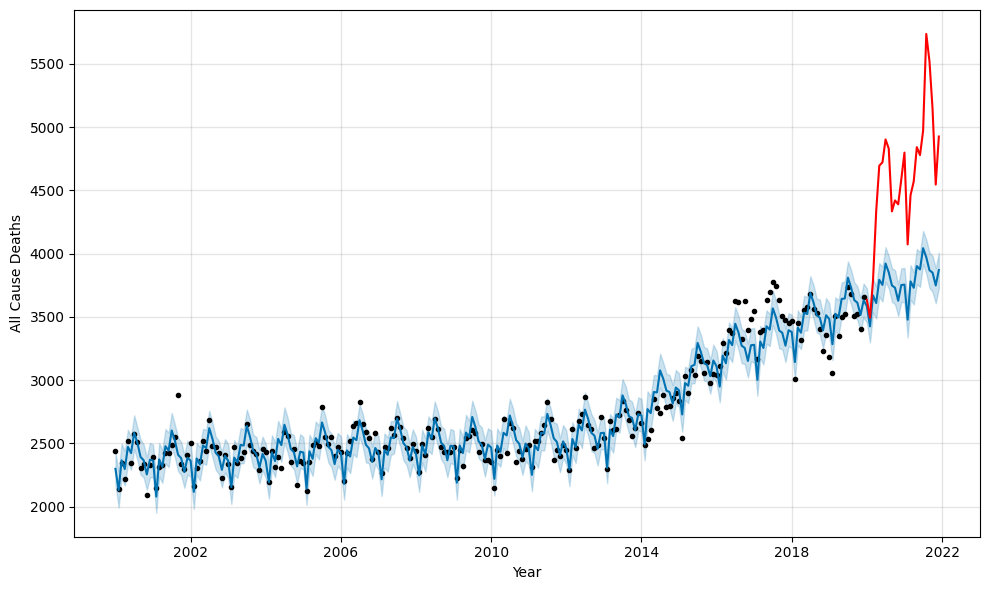

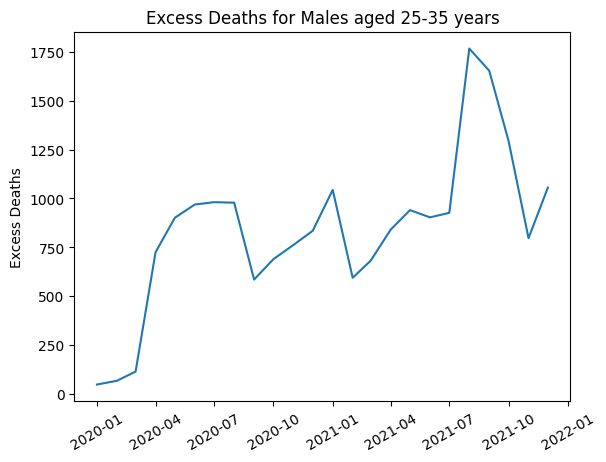

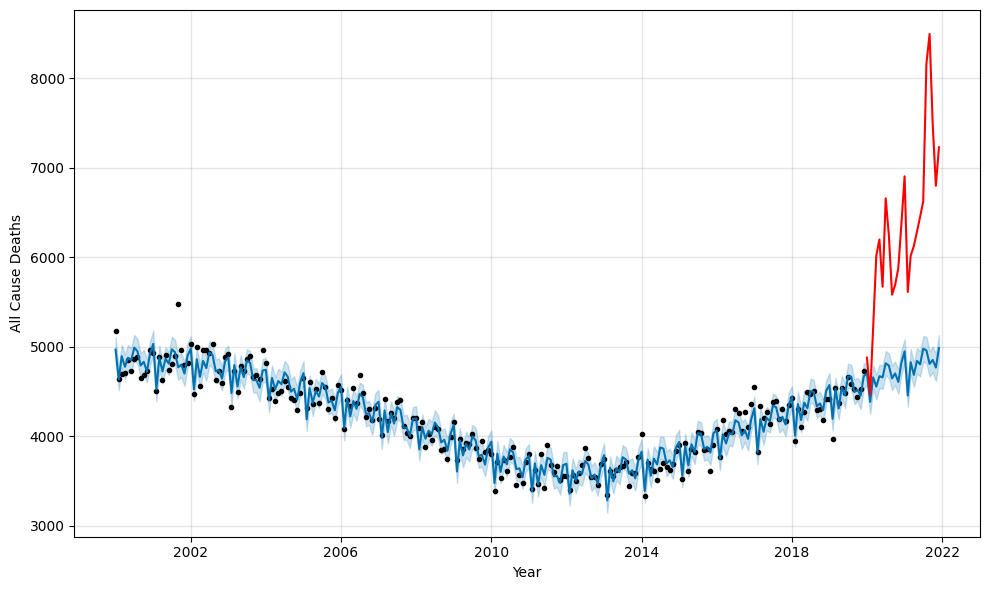

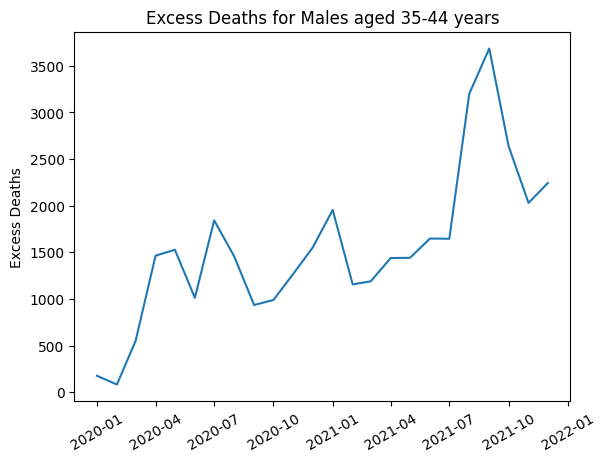

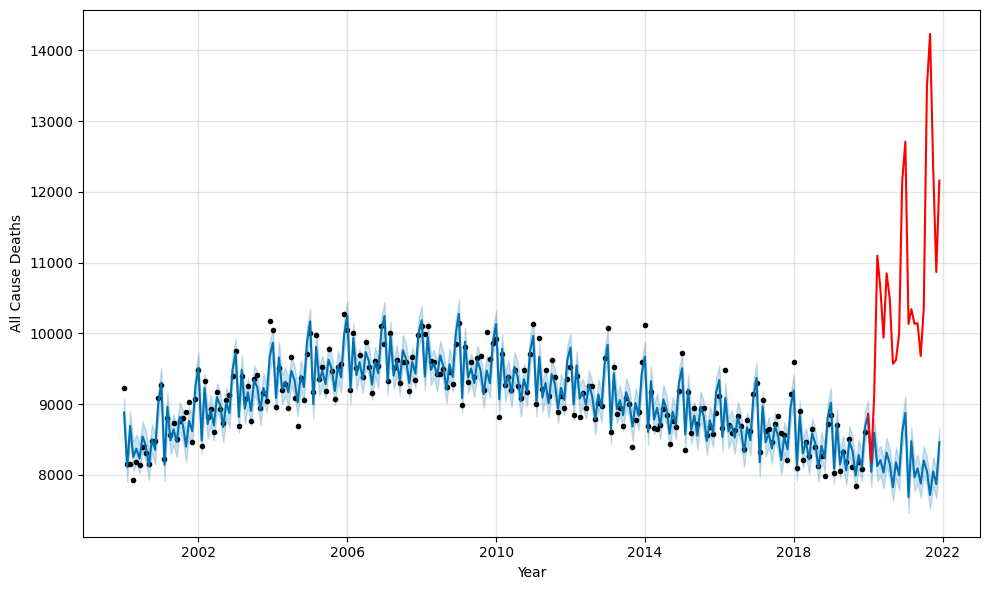

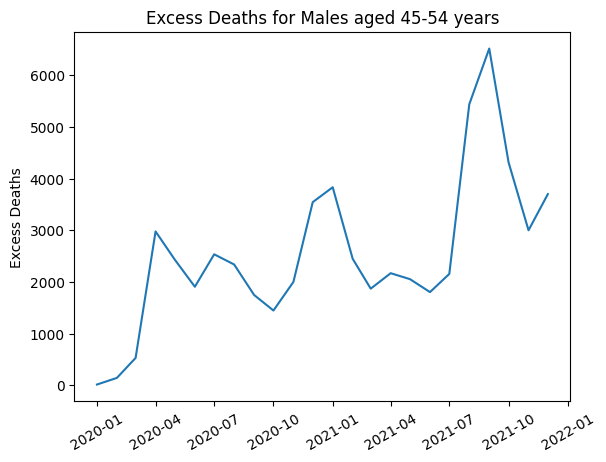

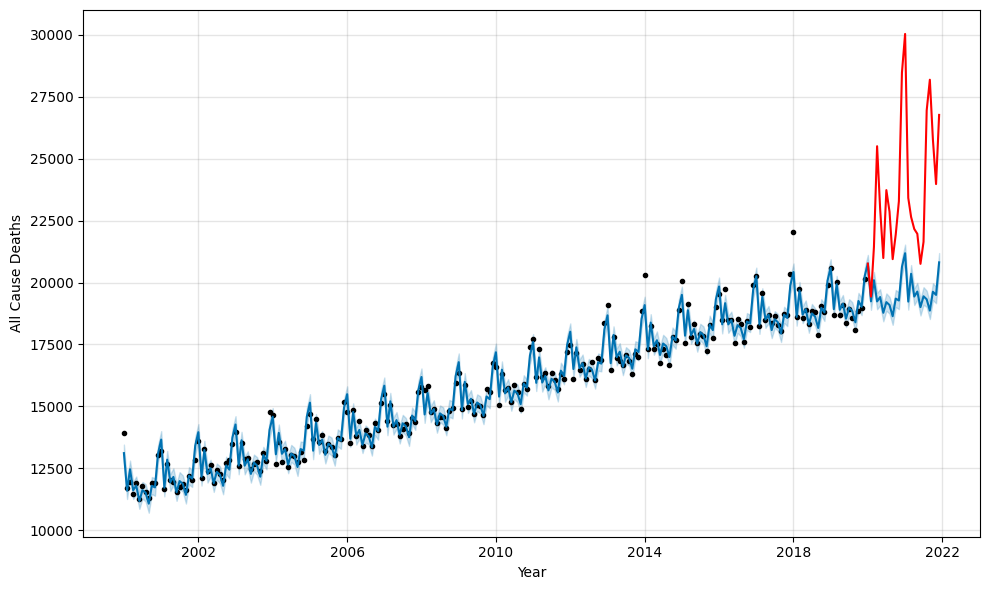

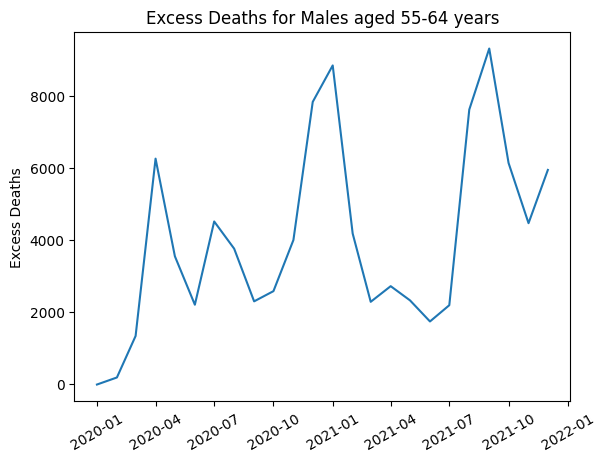

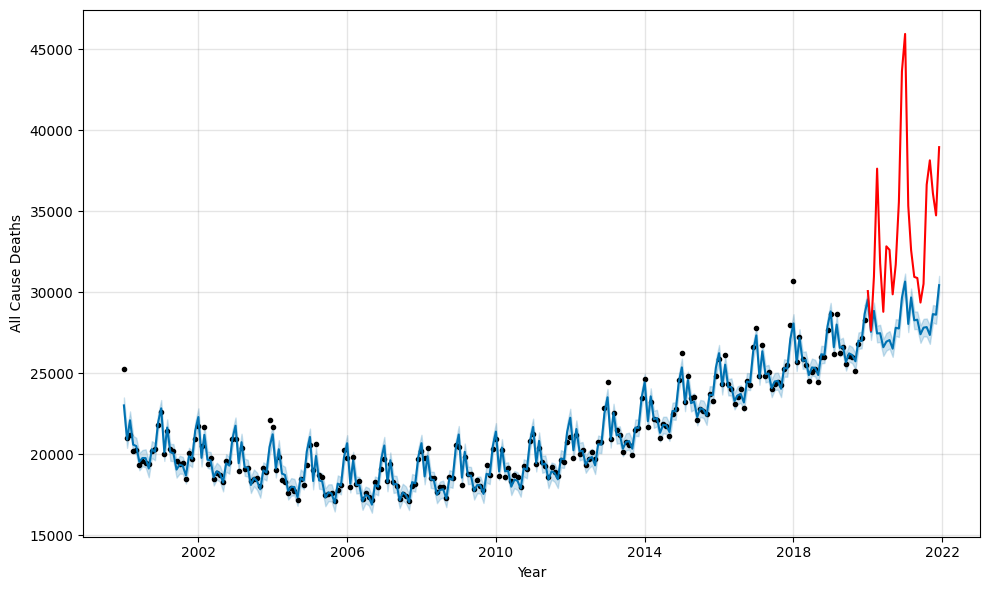

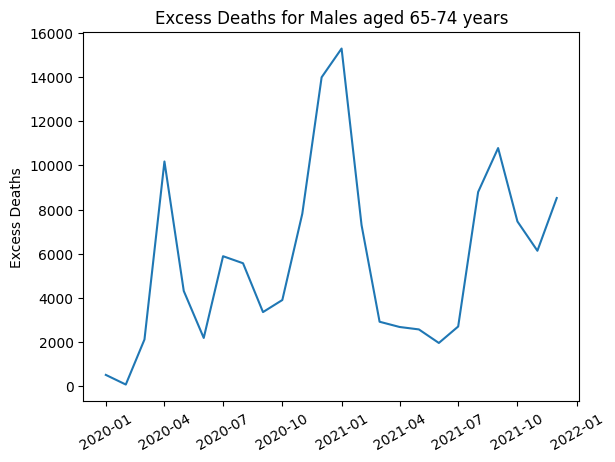

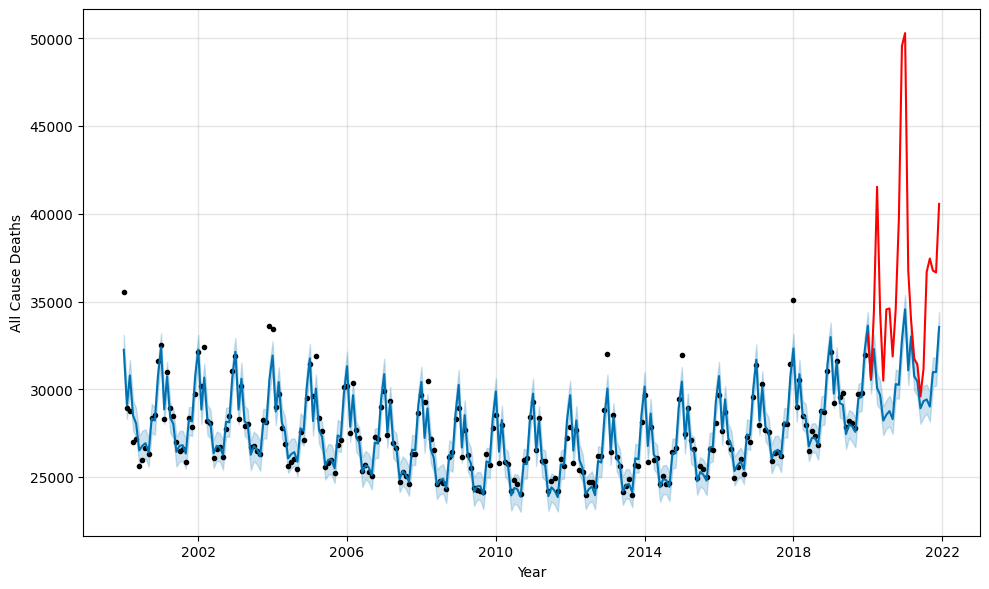

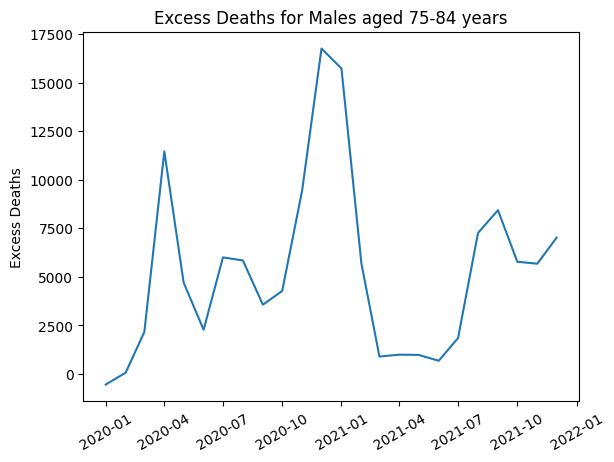

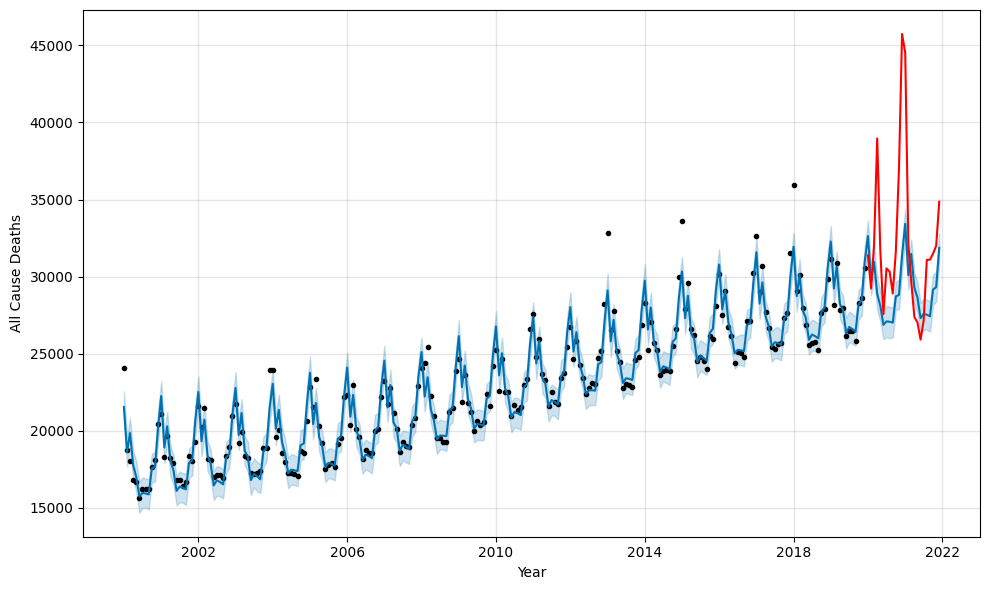

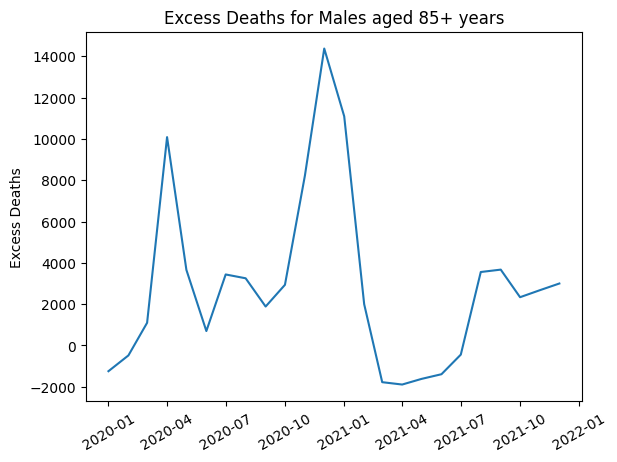

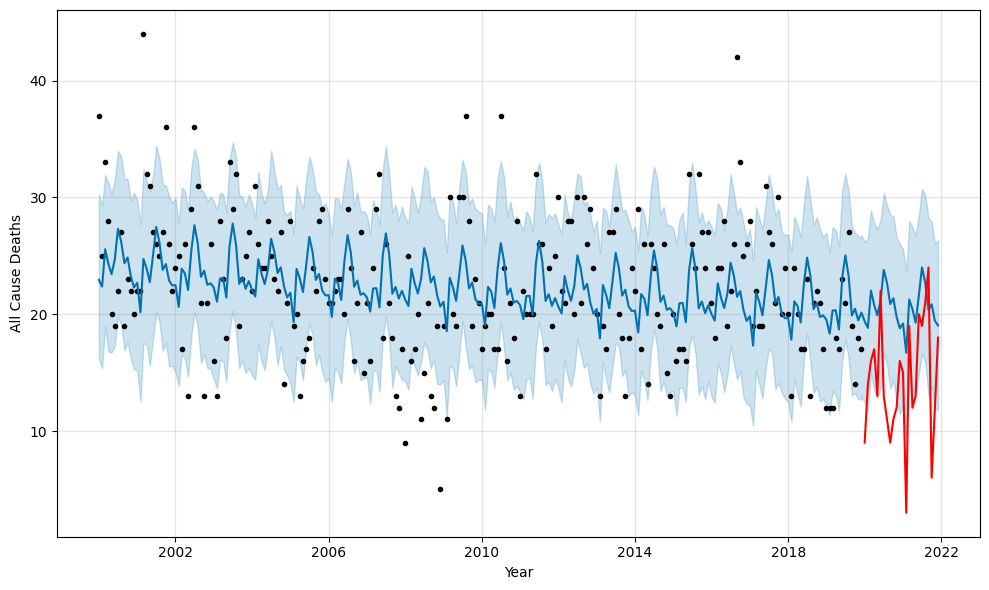

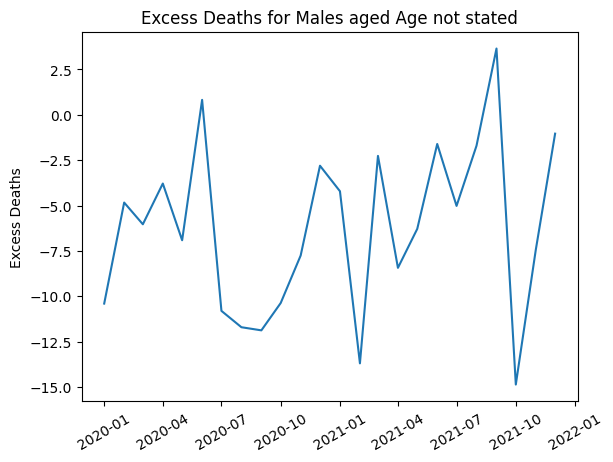

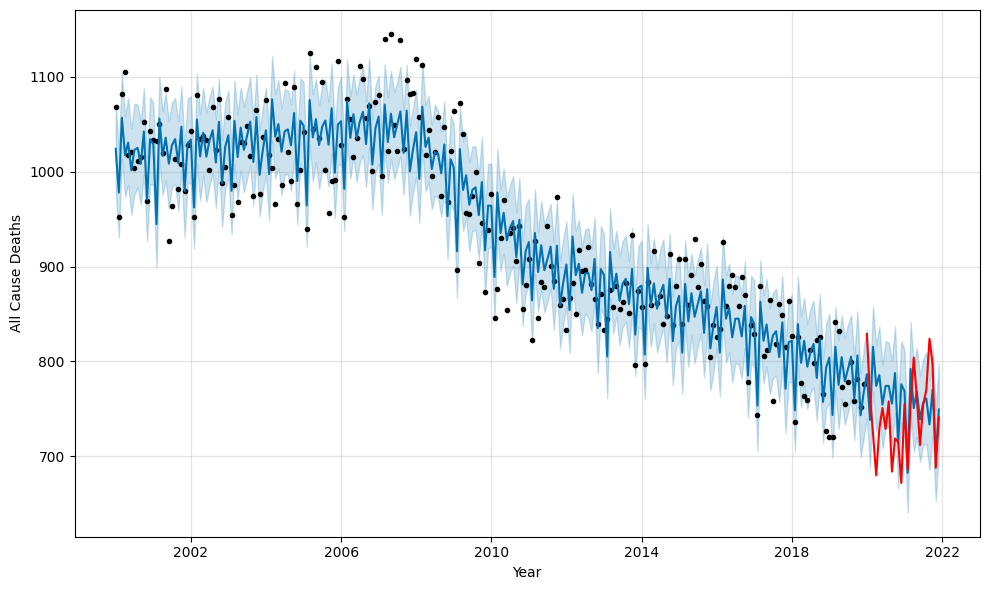

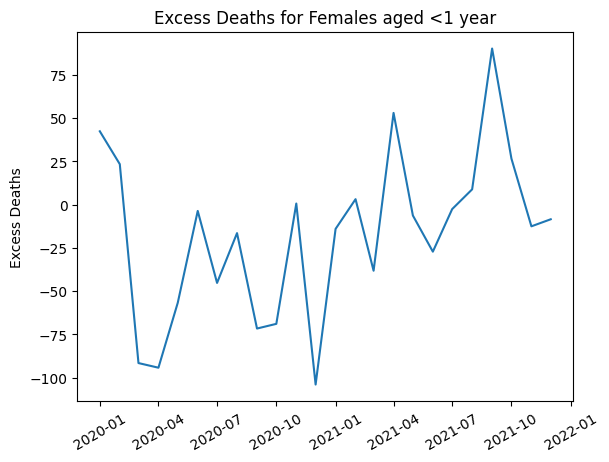

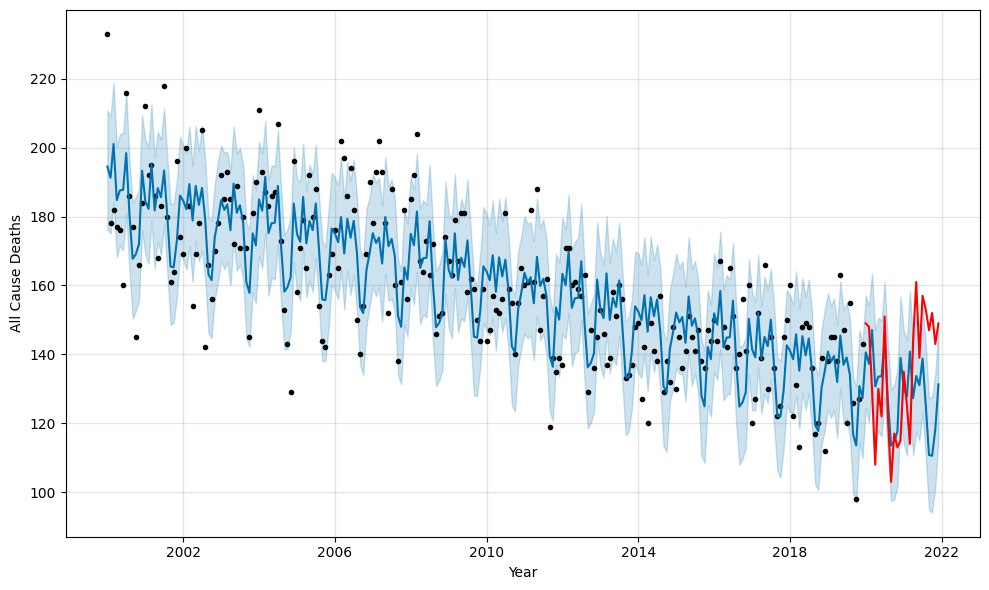

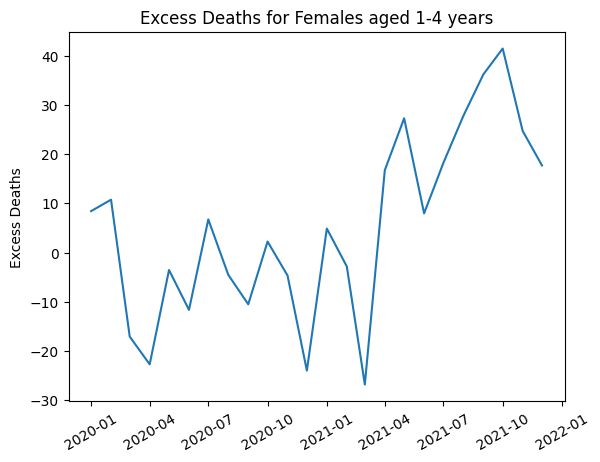

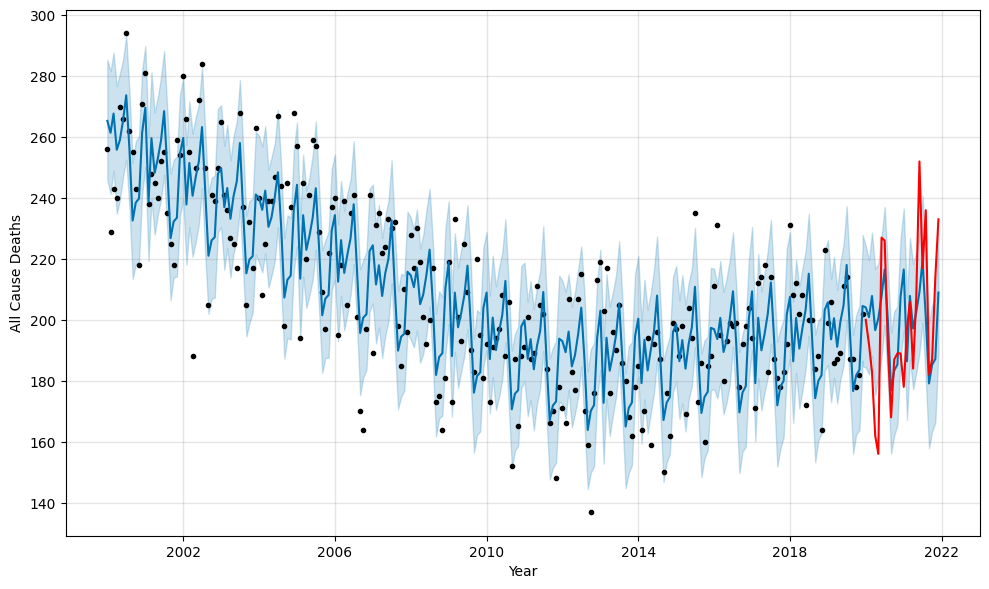

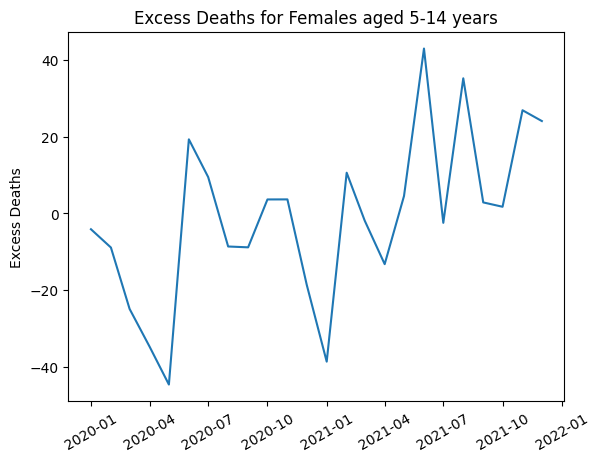

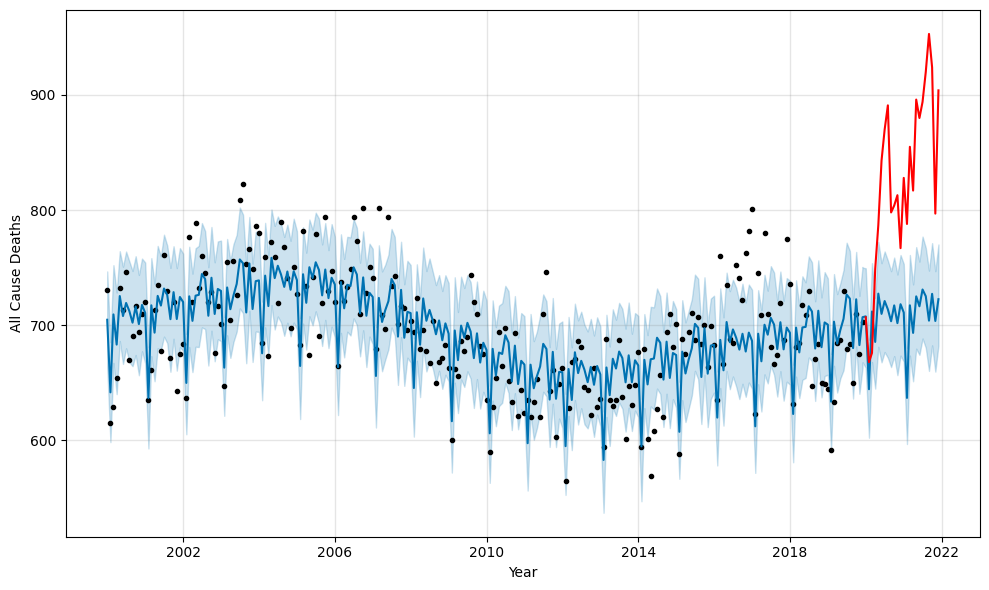

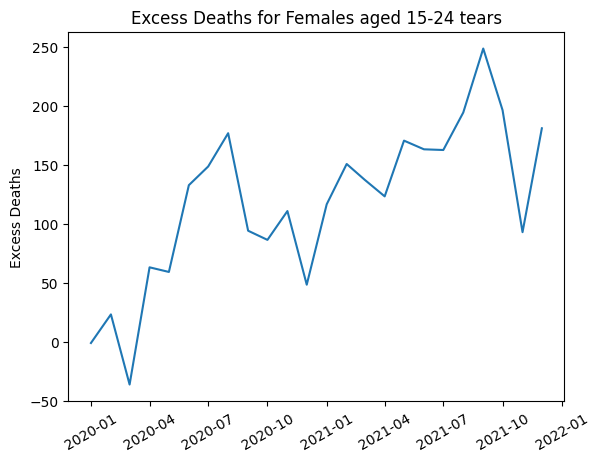

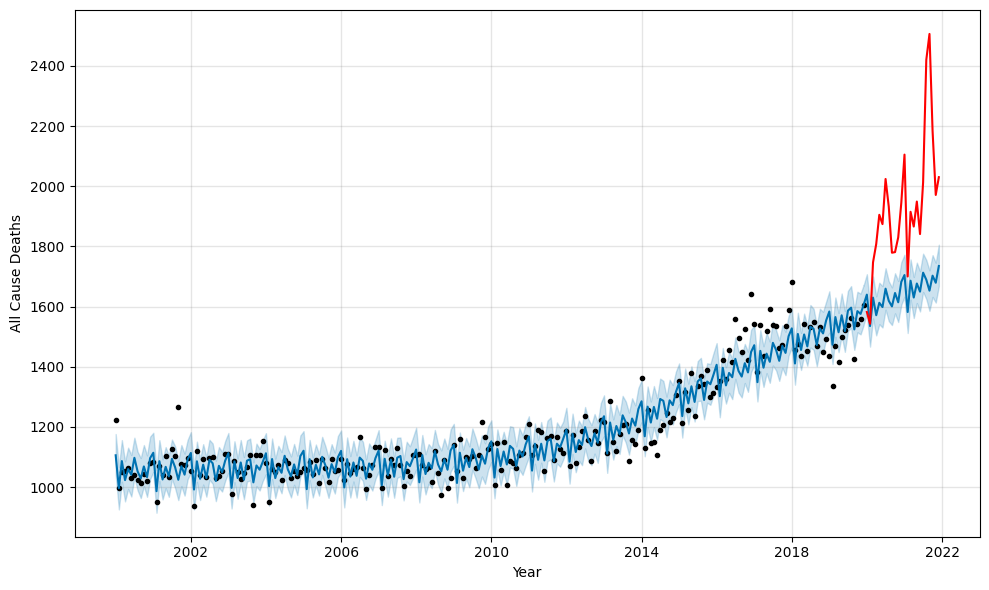

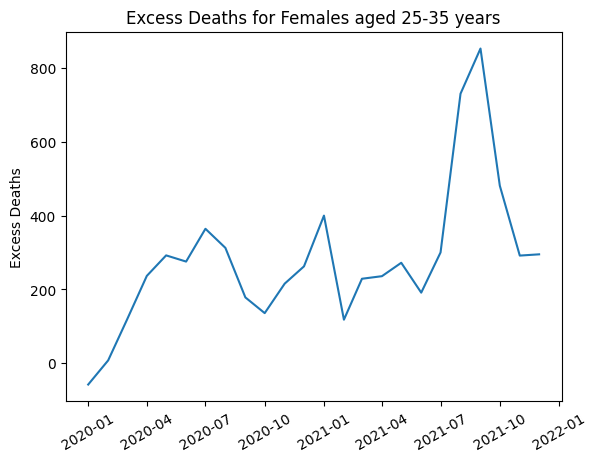

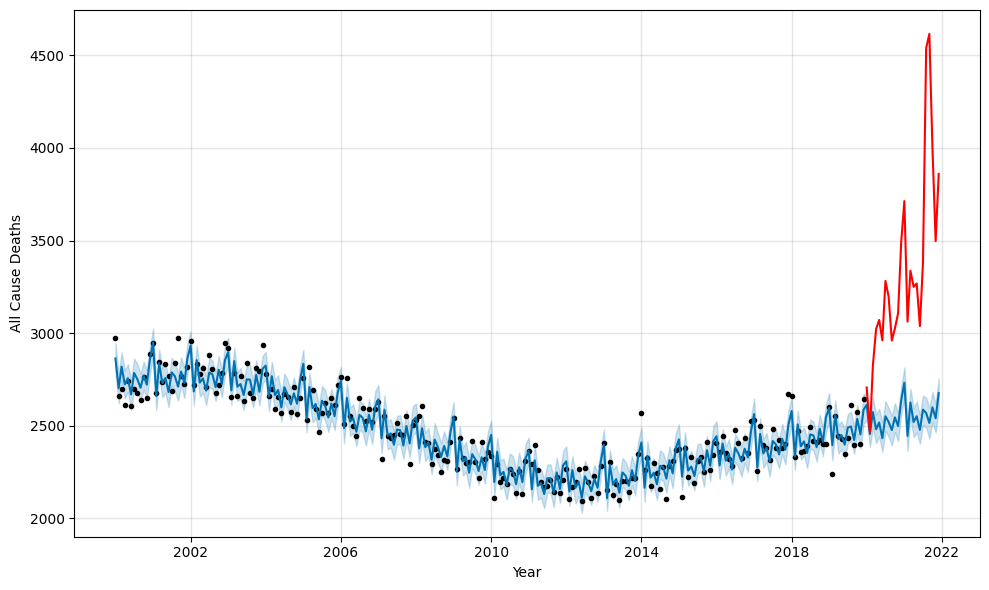

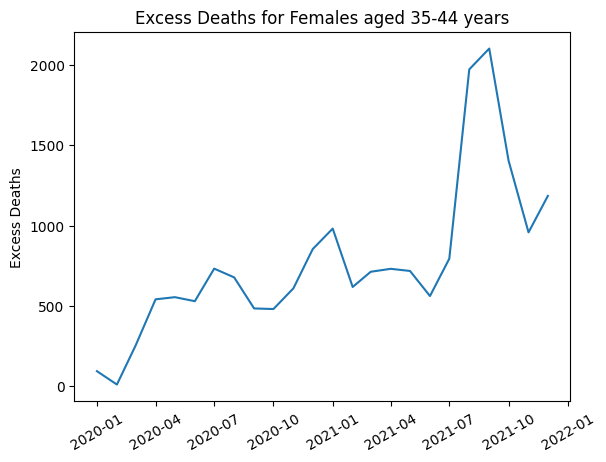

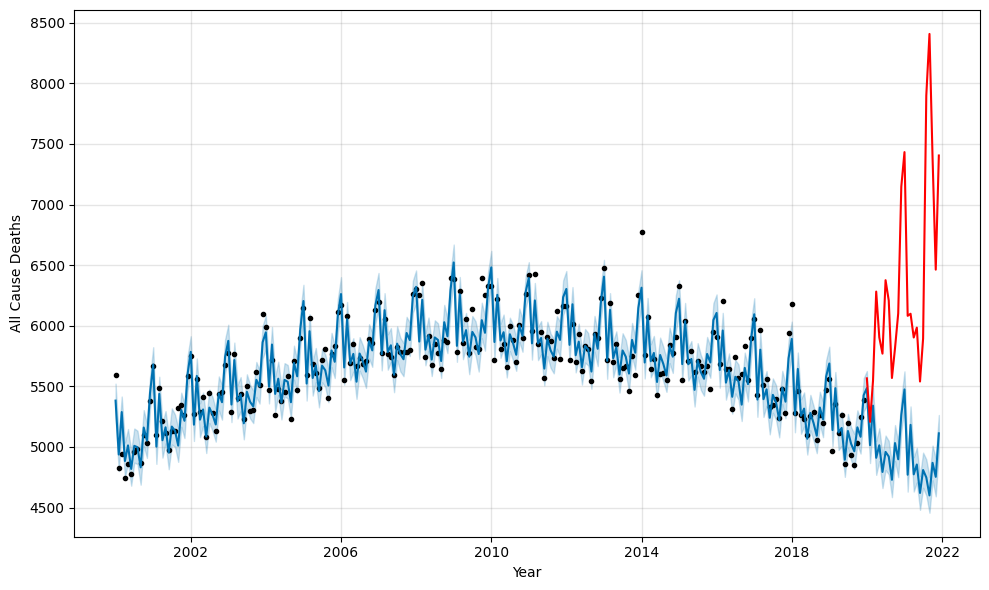

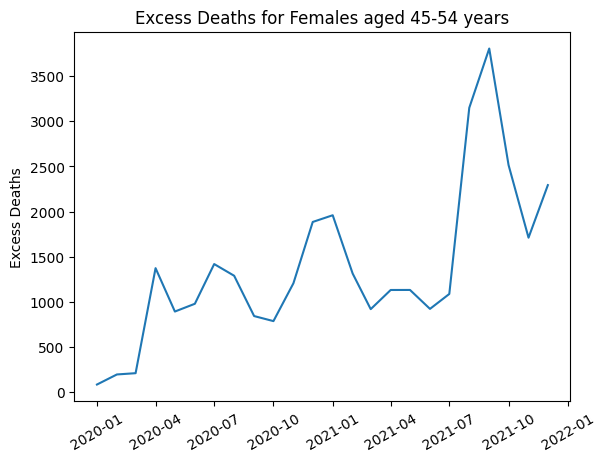

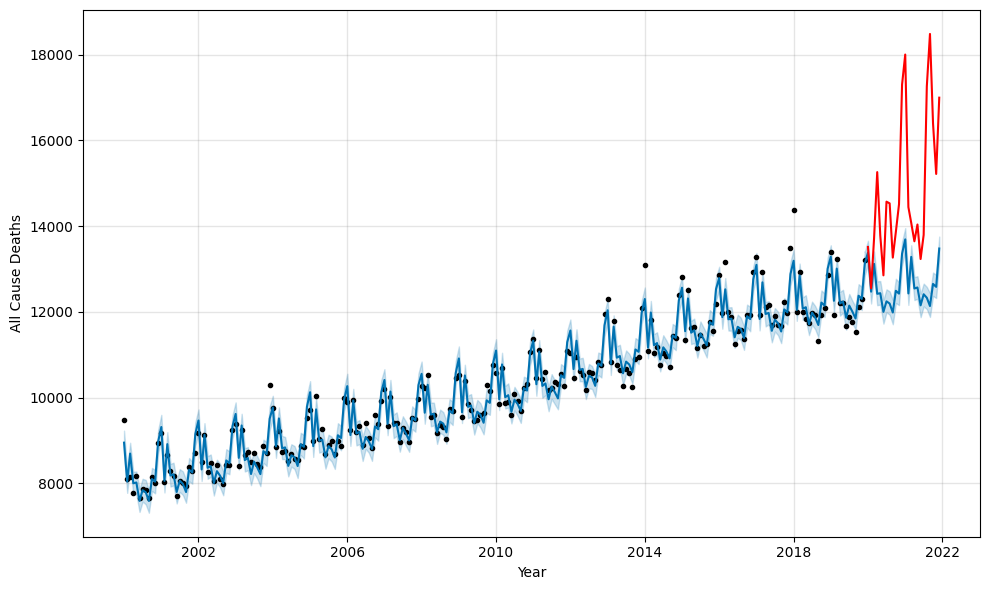

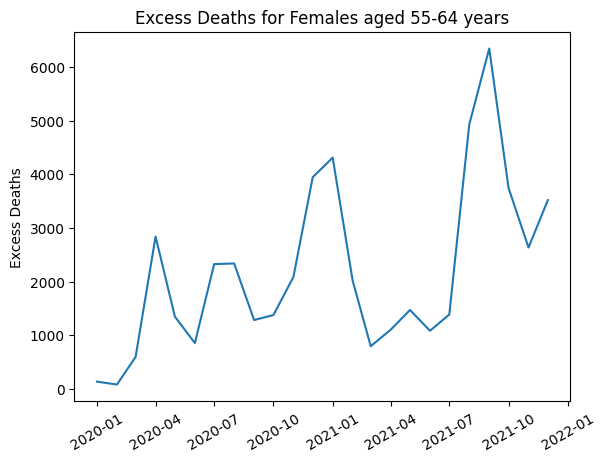

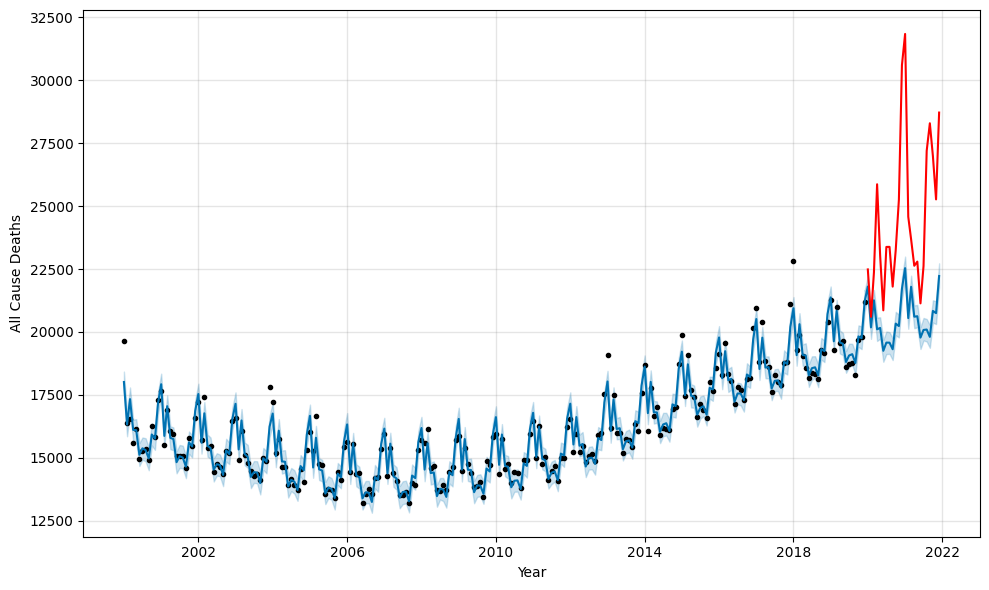

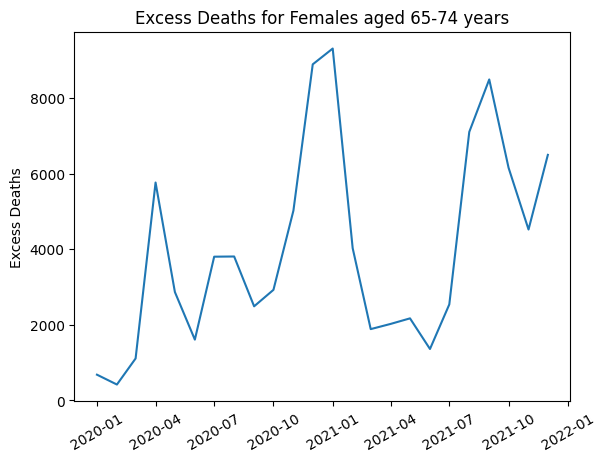

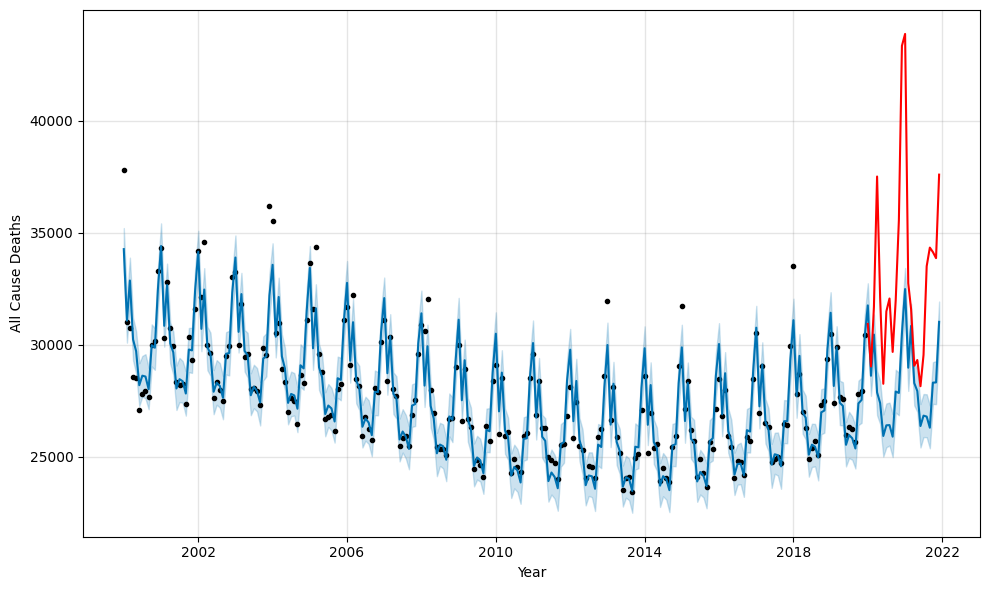

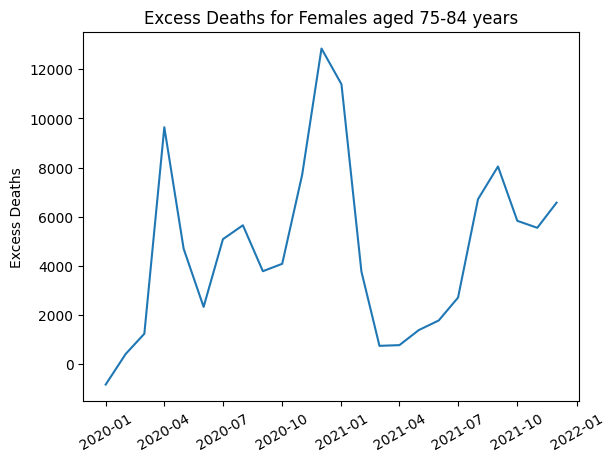

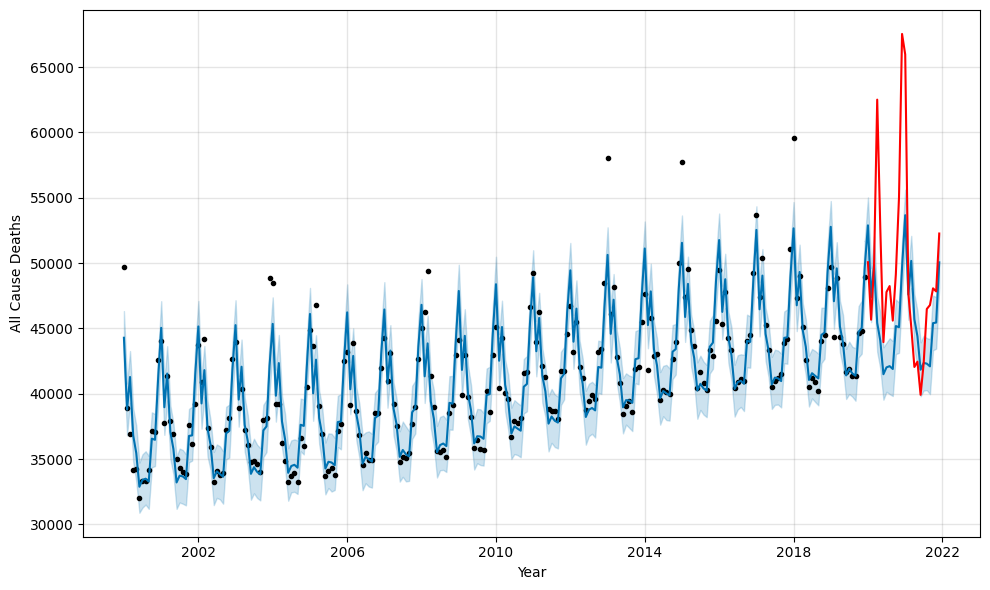

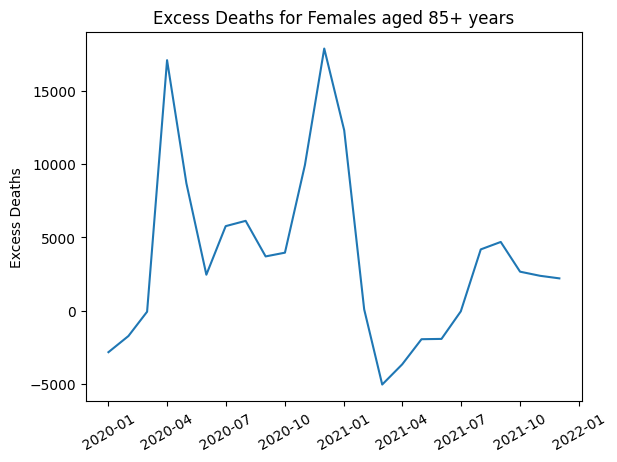

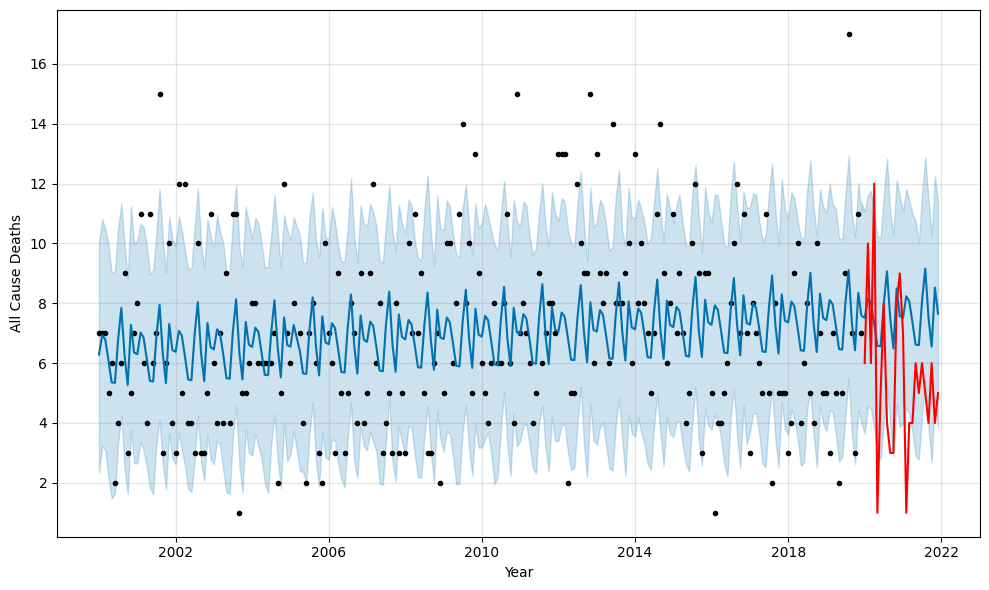

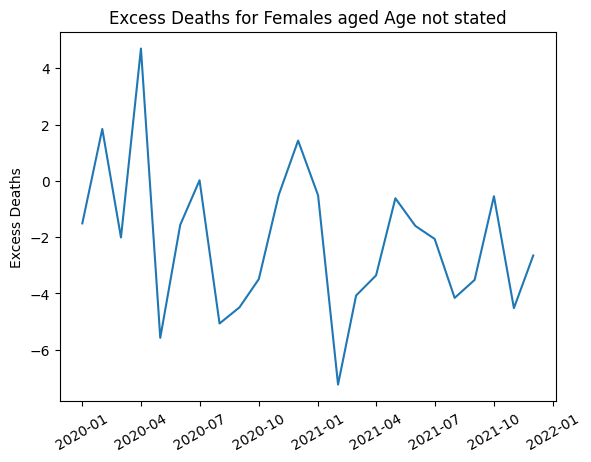

In [326]:
all_excess_deaths = pd.concat([compute_execss_deaths(recode, sex,data)[1] for sex in ['M', 'F'] \
                for recode in range(1, 13)])

In [323]:
all_excess_deaths.groupby(['sex']).excess_deaths.sum()

sex
F    407722.274901
M    556829.062595
Name: excess_deaths, dtype: float64

In [336]:
age_range_deaths = all_excess_deaths.groupby(['ager12', 'sex'])\
                    [['expected_deaths', 'excess_deaths']].sum().reset_index()

In [337]:
age_range_deaths['% Excess Deaths'] = age_range_deaths.apply(
        lambda x: (x.excess_deaths + x.expected_deaths)/x.expected_deaths - 1, axis=1
)

In [341]:
age_range_deaths['ager12'] = age_range_deaths.ager12.apply(lambda x: age_recode_map[x])

In [342]:
age_range_deaths.sort_values('% Excess Deaths', ascending=False)

ager12 sex  expected_deaths  excess_deaths  % Excess Deaths
11     35-44 years   M     1.139354e+05   37133.569064         0.325918
13     45-54 years   M     1.962192e+05   60870.756069         0.310218
10     35-44 years   F     6.112878e+04   18545.221164         0.303380
12     45-54 years   F     1.189314e+05   33059.588171         0.277972
9      25-35 years   M     9.034176e+04   20162.244615         0.223177
7      15-24 tears   M     4.492977e+04    9856.231803         0.219370
15     55-64 years   M     4.701158e+05   96443.246301         0.205148
17     65-74 years   M     6.761262e+05  137000.756950         0.202626
16     65-74 years   F     4.932004e+05   95480.623707         0.193594
14     55-64 years   F     3.027636e+05   52529.377070         0.173500
19     75-84 years   M     7.354169e+05  127079.119580         0.172799
8      25-35 years   F     3.950880e+04    6741.203751         0.170625
6      15-24 tears   F     1.697788e+04    2851.123257         0.167932
18     75-84 years   F     6.793235e+05  111938.528880         0.164779
21       85+ years   M     7.003784e+05   69101.552556         0.098663
20       85+ years   F     1.098230e+06   86941.247491         0.079165
5       5-14 years   M     6.405339e+03     474.660519         0.074104
2        1-4 years   F     3.104333e+03     122.667397         0.039515
3        1-4 years   M     4.108216e+03      43.783851         0.010658
4       5-14 years   F     4.787217e+03     -24.217197        -0.005059
0          <1 year   F     1.821099e+04    -411.986497        -0.022623
1          <1 year   M     2.302557e+04   -1187.572890        -0.051576
22  Age not stated   F     1.831023e+02     -51.102295        -0.279092
23  Age not stated   M     4.942858e+02    -149.285823        -0.302023

In [343]:
age_recode_map[6]

'35-44 years'

18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing


(<Figure size 640x480 with 1 Axes>,
     yearmonth  excess_deaths  expected_deaths sex  ager12
 0  2020-01-01     176.195579      4702.804421   M       6
 1  2020-02-01      82.172428      4384.827572   M       6
 2  2020-03-01     549.909365      4659.090635   M       6
 3  2020-04-01    1464.485068      4555.514932   M       6
 4  2020-05-01    1527.597934      4671.402066   M       6
 5  2020-06-01    1012.186805      4658.813195   M       6
 6  2020-07-01    1842.657465      4815.342535   M       6
 7  2020-08-01    1457.128776      4789.871224   M       6
 8  2020-09-01     935.176918      4646.823082   M       6
 9  2020-10-01     989.052945      4702.947055   M       6
 10 2020-11-01    1271.748012      4607.251988   M       6
 11 2020-12-01    1552.434082      4822.565918   M       6
 12 2021-01-01    1954.717123      4949.282877   M       6
 13 2021-02-01    1156.296191      4455.703809   M       6
 14 2021-03-01    1189.251110      4827.748890   M       6
 15 2021-04-01    14

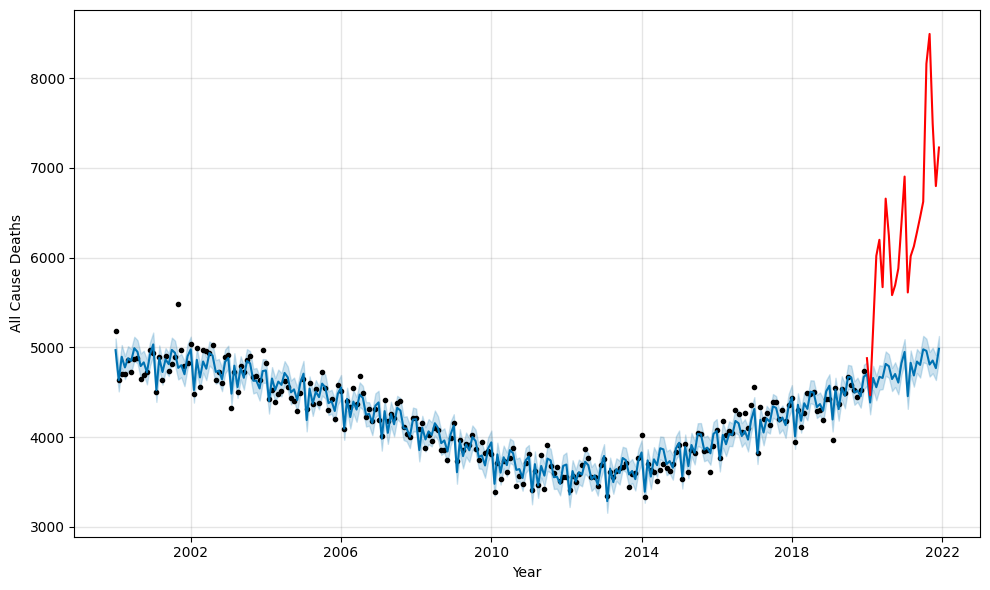

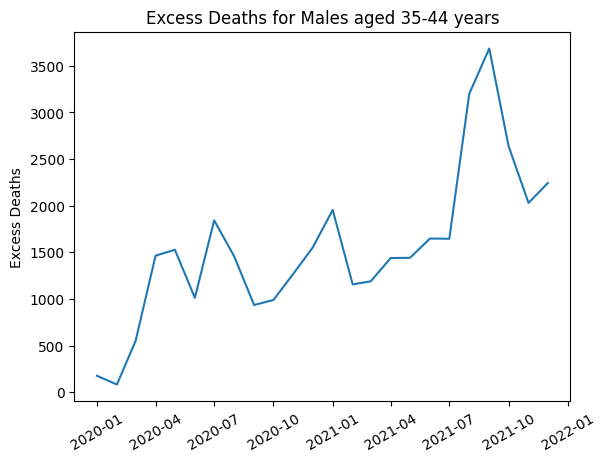

In [344]:
compute_execss_deaths(6, 'M',data)

19:26:46 - cmdstanpy - INFO - Chain [1] start processing
19:26:46 - cmdstanpy - INFO - Chain [1] done processing


(<Figure size 640x480 with 1 Axes>,
     yearmonth  excess_deaths  expected_deaths sex  ager12
 0  2020-01-01     112.259530      1776.740470   M       4
 1  2020-02-01     147.312625      1587.687375   M       4
 2  2020-03-01     121.559867      1849.440133   M       4
 3  2020-04-01     270.672241      1807.327759   M       4
 4  2020-05-01     334.644127      1959.355873   M       4
 5  2020-06-01     431.258752      1978.741248   M       4
 6  2020-07-01     521.253688      2117.746312   M       4
 7  2020-08-01     466.859766      2039.140234   M       4
 8  2020-09-01     458.379788      1889.620212   M       4
 9  2020-10-01     385.888796      1889.111204   M       4
 10 2020-11-01     412.936812      1795.063188   M       4
 11 2020-12-01     460.115374      1828.884626   M       4
 12 2021-01-01     508.469745      1774.530255   M       4
 13 2021-02-01     331.888583      1546.111417   M       4
 14 2021-03-01     438.235136      1827.764864   M       4
 15 2021-04-01     5

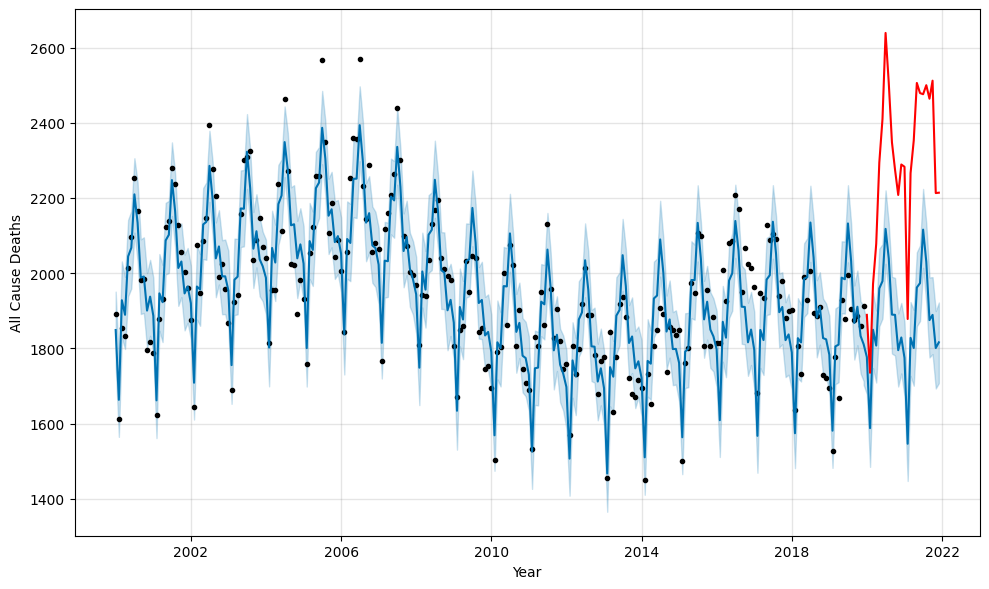

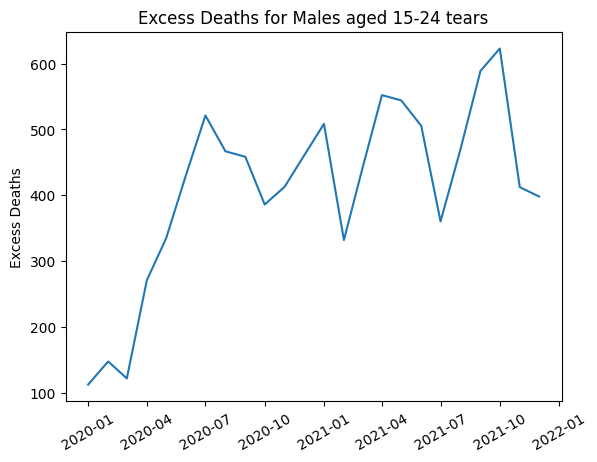

In [348]:
compute_execss_deaths(4, 'M',data)

09:20:02 - cmdstanpy - INFO - Chain [1] start processing
09:20:02 - cmdstanpy - INFO - Chain [1] done processing


(<Figure size 640x480 with 1 Axes>,
     yearmonth  excess_deaths  expected_deaths sex  ager12
 0  2020-01-01      -3.870333     20765.870333   M       8
 1  2020-02-01     192.132931     19238.867069   M       8
 2  2020-03-01    1343.839404     20093.160596   M       8
 3  2020-04-01    6264.960343     19236.039657   M       8
 4  2020-05-01    3555.514575     19413.485425   M       8
 5  2020-06-01    2211.401121     18776.598879   M       8
 6  2020-07-01    4521.678691     19207.321309   M       8
 7  2020-08-01    3767.138803     19091.861197   M       8
 8  2020-09-01    2304.896107     18638.103893   M       8
 9  2020-10-01    2587.981882     19349.018118   M       8
 10 2020-11-01    4006.773654     19274.226346   M       8
 11 2020-12-01    7840.690310     20629.309690   M       8
 12 2021-01-01    8851.833483     21181.166517   M       8
 13 2021-02-01    4186.168456     19229.831544   M       8
 14 2021-03-01    2292.045019     20350.954981   M       8
 15 2021-04-01    27

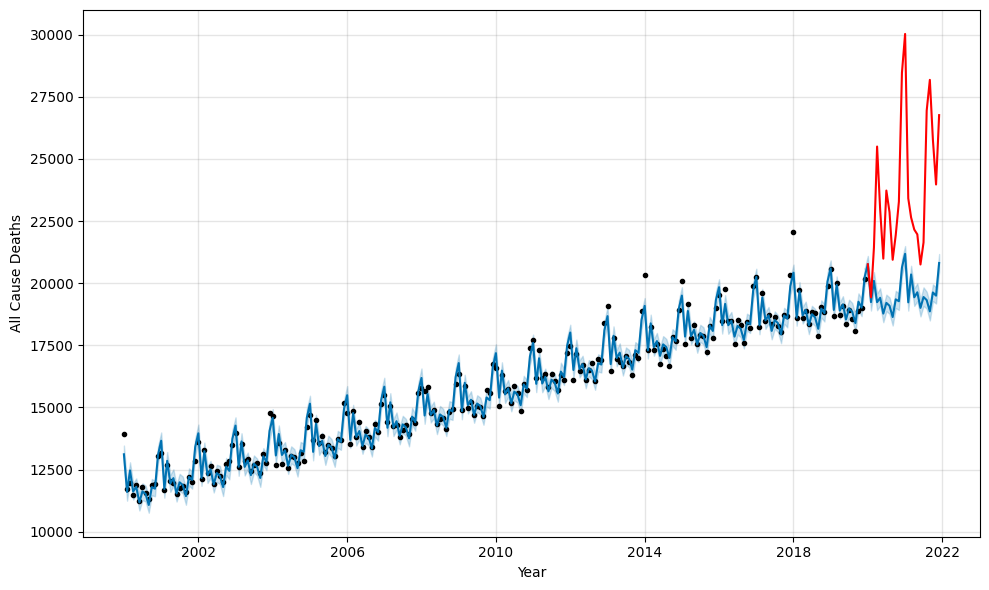

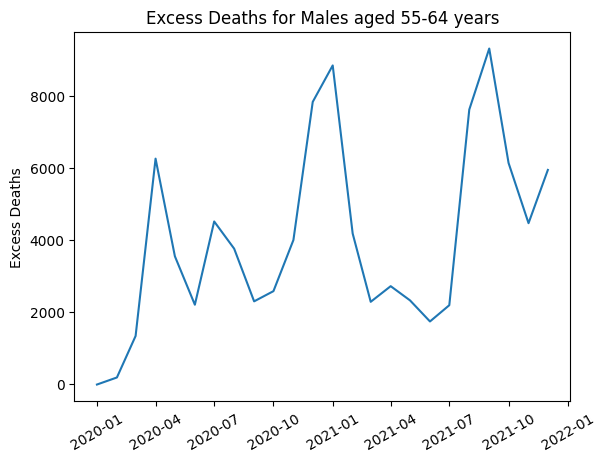

In [69]:
compute_execss_deaths(8, 'M',data)

In [9]:
from allcause.data import get_vaccination_data

In [10]:
vaccination_data = get_vaccination_data()

In [11]:
first_of_month = vaccination_data[vaccination_data.day == 1]

<Axes: xlabel='date', ylabel='Administered_Dose1_pct_agegroup'>

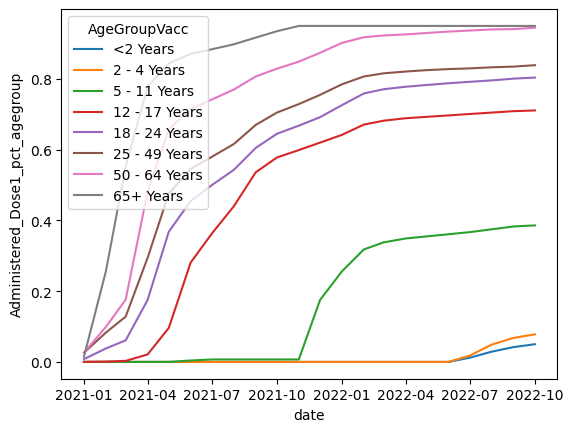

In [12]:
sns.lineplot(
x='date',
y='Administered_Dose1_pct_agegroup',
hue='AgeGroupVacc',
data=first_of_month)

In [13]:
from allcause.data import get_covid_data

In [20]:
covid_data = get_covid_data()

In [21]:
covid_data['End Week'] = covid_data['End Week'].map(pd.to_datetime)

In [22]:
covid_data['yearmonth'] = covid_data['End Week'].map(lambda x: datetime(x.year, x.month, 1))
covid_data = covid_data[covid_data.Sex.isin(['Male', 'Female']) &
                       (covid_data.State == 'United States')]
covid_data = covid_data.rename({'Total Deaths' : 'death_count',
                                'COVID-19 Deaths' : 'covid_deaths',
                               'Sex': 'sex'},
                              axis=1)

In [33]:
covid_data = covid_data.groupby(['sex', 'Age Group', 'yearmonth'])\
                    [['death_count', 'covid_deaths']].sum().reset_index()
covid_data['Age Group'] = covid_data['Age Group'].map(lambda x:
                                         x.lower().replace('under ', '<').replace(' years and over', '+ years'))


In [41]:
inverse_recode_map = {v : k for k, v in age_recode_map.items()}

In [47]:
covid_data = covid_data.rename({'Age Group' : 'ager12'}, axis=1)
covid_data = covid_data[covid_data.ager12 != 'all ages']

In [48]:
covid_data.ager12.unique()

array(['1-4 years', '15-24 years', '25-34 years', '35-44 years',
       '45-54 years', '5-14 years', '55-64 years', '65-74 years',
       '75-84 years', '85+ years', '<1 year'], dtype=object)

In [49]:
covid_data['ager12'] = covid_data['ager12'].map(lambda x: inverse_recode_map[x])

In [51]:
covid_data['sex'] = covid_data['sex'].map(lambda x: x[0])

In [60]:
covid_over_time = covid_data.groupby('yearmonth')['death_count'].sum().reset_index()

(array([18262., 18383., 18506., 18628., 18748., 18871., 18993., 19113.,
        19236., 19358.]),
 [Text(18262.0, 0, '2020-01'),
  Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09'),
  Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01')])

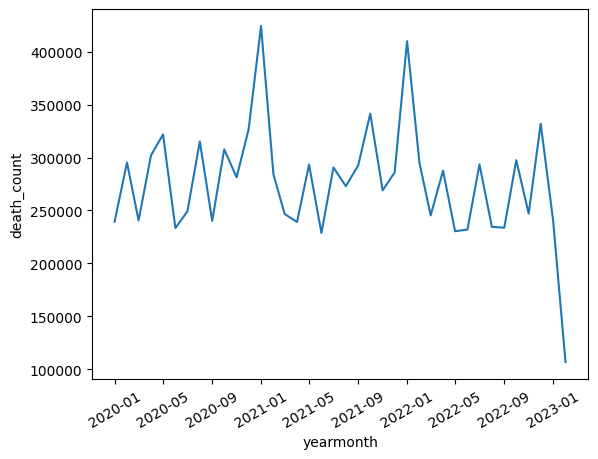

In [61]:
sns.lineplot(x='yearmonth',
            y='death_count',
            data=covid_over_time)
plt.xticks(rotation=30)

In [55]:
data[(data.yearmonth==datetime(2020, 1, 1)) & (data.sex == 'F')]

ager12  monthdth sex  death_count  year  yearmonth
0         1         1   F          829  2020 2020-01-01
24        2         1   F          149  2020 2020-01-01
48        3         1   F          200  2020 2020-01-01
72        4         1   F          707  2020 2020-01-01
96        5         1   F         1582  2020 2020-01-01
120       6         1   F         2706  2020 2020-01-01
144       7         1   F         5566  2020 2020-01-01
168       8         1   F        13514  2020 2020-01-01
192       9         1   F        22486  2020 2020-01-01
216      10         1   F        30924  2020 2020-01-01
240      11         1   F        50070  2020 2020-01-01
264      12         1   F            6  2020 2020-01-01

In [66]:
data_2022 = covid_data.drop('covid_deaths', axis=1)
data_2022['monthdth'] = data_2022.yearmonth.apply(lambda x: x.month)
data_2022['year'] = data_2022.yearmonth.apply(lambda x: x.year)
data_2022 = data_2022[data_2022.year==2022]

In [67]:
data_2022

sex  ager12  yearmonth  death_count  monthdth  year
24    F       2 2022-01-01          160         1  2022
25    F       2 2022-02-01          114         2  2022
26    F       2 2022-03-01          117         3  2022
27    F       2 2022-04-01          160         4  2022
28    F       2 2022-05-01          143         5  2022
..   ..     ...        ...          ...       ...   ...
905   M       1 2022-08-01          915         8  2022
906   M       1 2022-09-01          870         9  2022
907   M       1 2022-10-01         1089        10  2022
908   M       1 2022-11-01          808        11  2022
909   M       1 2022-12-01          957        12  2022

[264 rows x 6 columns]